--- Step 1: Data Loading, Cleaning, and Exploration ---
Dataset loaded successfully.

Cleaning data...
Data cleaning complete.

Preparing data for mining (creating transaction matrix)...


/var/folders/32/p06zg5x177sb5n178c53__5r0000gn/T/ipykernel_6176/2077924450.py:44: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_sets = basket.applymap(encode_units)


Transaction matrix created.

Generating visualization for top 20 frequent items...


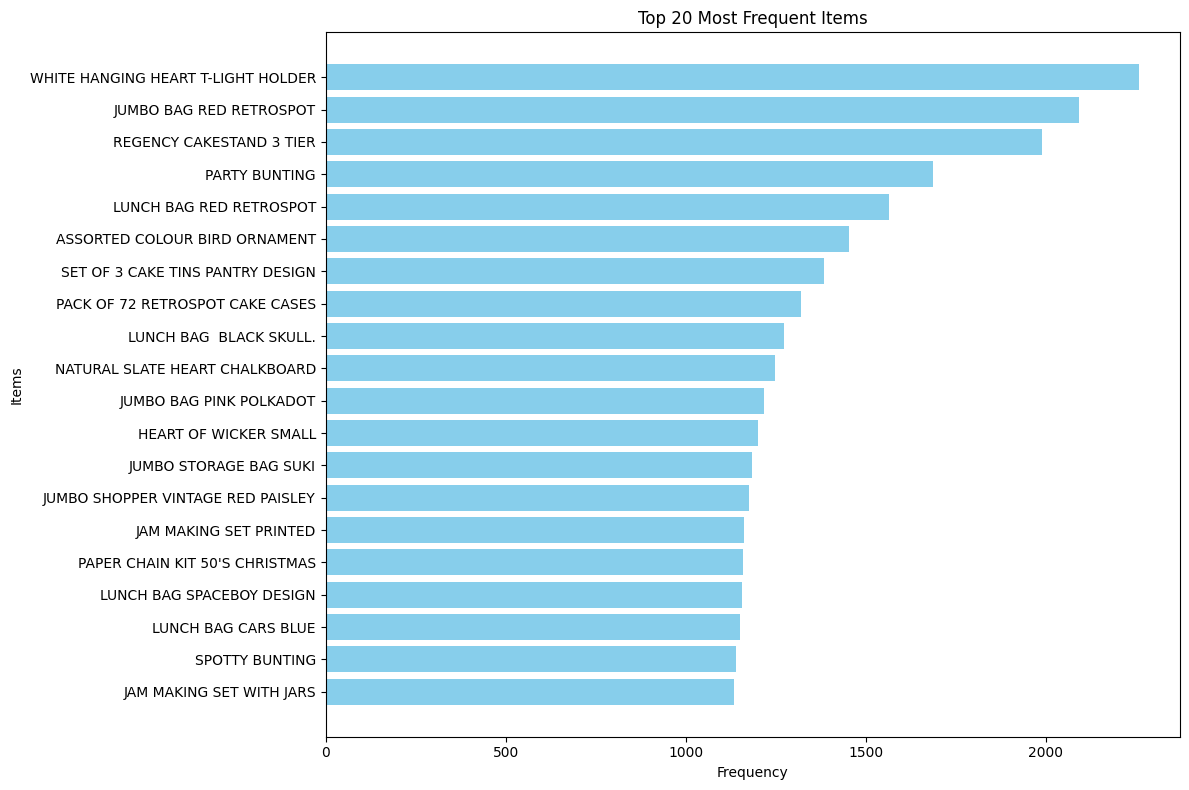


Generating visualization for item co-occurrence heatmap...


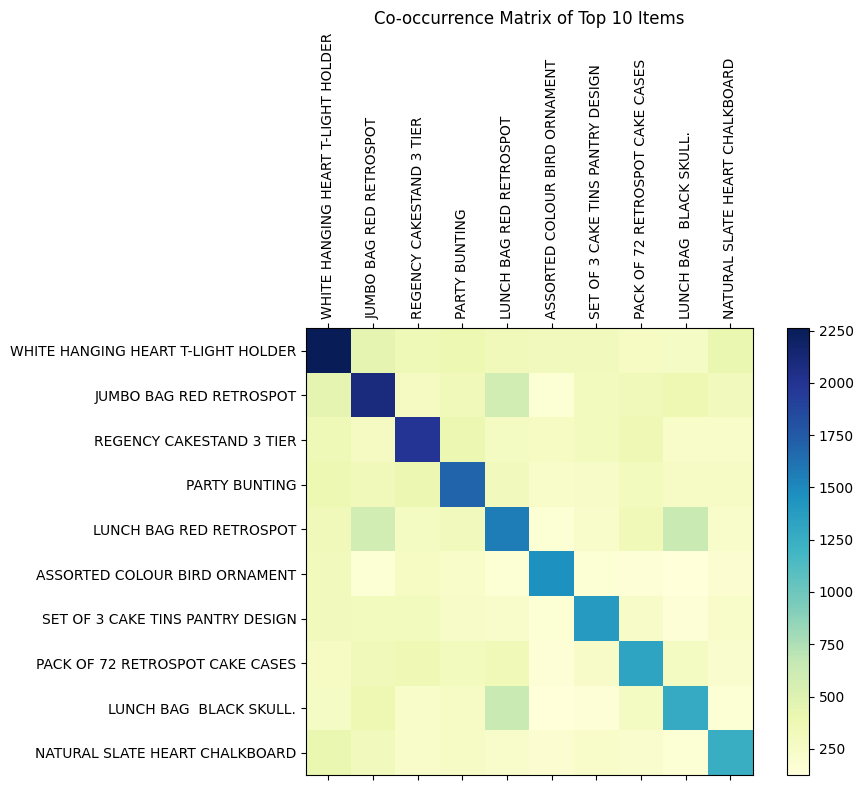

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import time
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules

# --- Step 1: Data Loading, Cleaning, and Exploration ---

print("--- Step 1: Data Loading, Cleaning, and Exploration ---")

# Load the dataset from the URL
# Note: This file is large and may take a moment to download and load.
df = pd.read_excel('http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')
print("Dataset loaded successfully.")

## Data Cleaning
print("\nCleaning data...")
# Remove rows with missing InvoiceNo or Description
df.dropna(axis=0, subset=['InvoiceNo', 'Description'], inplace=True)
# Convert InvoiceNo to string to handle potential numeric misinterpretations
df['InvoiceNo'] = df['InvoiceNo'].astype('str')
# Remove cancelled orders (invoices starting with 'C')
df = df[~df['InvoiceNo'].str.contains('C')]
# Remove transactions with non-positive quantities
df = df[df['Quantity'] > 0]
# Trim whitespace from descriptions
df['Description'] = df['Description'].str.strip()
print("Data cleaning complete.")

## Preparing Data for Mining (One-Hot Encoding)
# Group by transaction (InvoiceNo) and item (Description), then one-hot encode
# We sum quantities for items within the same invoice, then convert to 1 if present, 0 otherwise.
print("\nPreparing data for mining (creating transaction matrix)...")
basket = (df.groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

# Binarize the data: 1 if item was bought, 0 otherwise
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)
# Dropping the 'POSTAGE' column as it's a service, not a product.
if 'POSTAGE' in basket_sets.columns:
    basket_sets.drop('POSTAGE', inplace=True, axis=1)

print("Transaction matrix created.")


## Visualization 1: Top 20 Most Frequent Items
print("\nGenerating visualization for top 20 frequent items...")
item_counts = basket_sets.sum().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(item_counts.index[:20], item_counts.values[:20], color='skyblue')
plt.xlabel("Frequency")
plt.ylabel("Items")
plt.title("Top 20 Most Frequent Items")
plt.gca().invert_yaxis() # To display the most frequent item at the top
plt.tight_layout()
plt.show()

## Visualization 2: Item Co-occurrence Heatmap for Top 10 Items
print("\nGenerating visualization for item co-occurrence heatmap...")
top_10_items = item_counts.index[:10]
top_10_df = basket_sets[top_10_items]

# Calculate co-occurrence matrix
co_occurrence_matrix = top_10_df.T.dot(top_10_df)

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(co_occurrence_matrix, cmap='YlGnBu')
fig.colorbar(cax)

# Set up axes
ax.set_xticks(range(len(top_10_items)))
ax.set_yticks(range(len(top_10_items)))
ax.set_xticklabels(top_10_items, rotation=90)
ax.set_yticklabels(top_10_items)
plt.title("Co-occurrence Matrix of Top 10 Items")
plt.tight_layout()
plt.show()










--- Step 2: Frequent Itemset Mining Using Apriori ---


/Users/sakchhamsangroula/School/Big data/Lab6/venv/lib/python3.13/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Apriori algorithm took 6.5021 seconds.

Top 10 frequent itemsets found by Apriori:
      support                              itemsets
273  0.112237  (WHITE HANGING HEART T-LIGHT HOLDER)
102  0.103894             (JUMBO BAG RED RETROSPOT)
196  0.098778            (REGENCY CAKESTAND 3 TIER)
157  0.083731                       (PARTY BUNTING)
127  0.077672             (LUNCH BAG RED RETROSPOT)
15   0.072259       (ASSORTED COLOUR BIRD ORNAMENT)
218  0.068782    (SET OF 3 CAKE TINS PANTRY DESIGN)
149  0.065554     (PACK OF 72 RETROSPOT CAKE CASES)
120  0.063220             (LUNCH BAG  BLACK SKULL.)
139  0.062028      (NATURAL SLATE HEART CHALKBOARD)

Generating visualization for top 10 frequent itemsets...


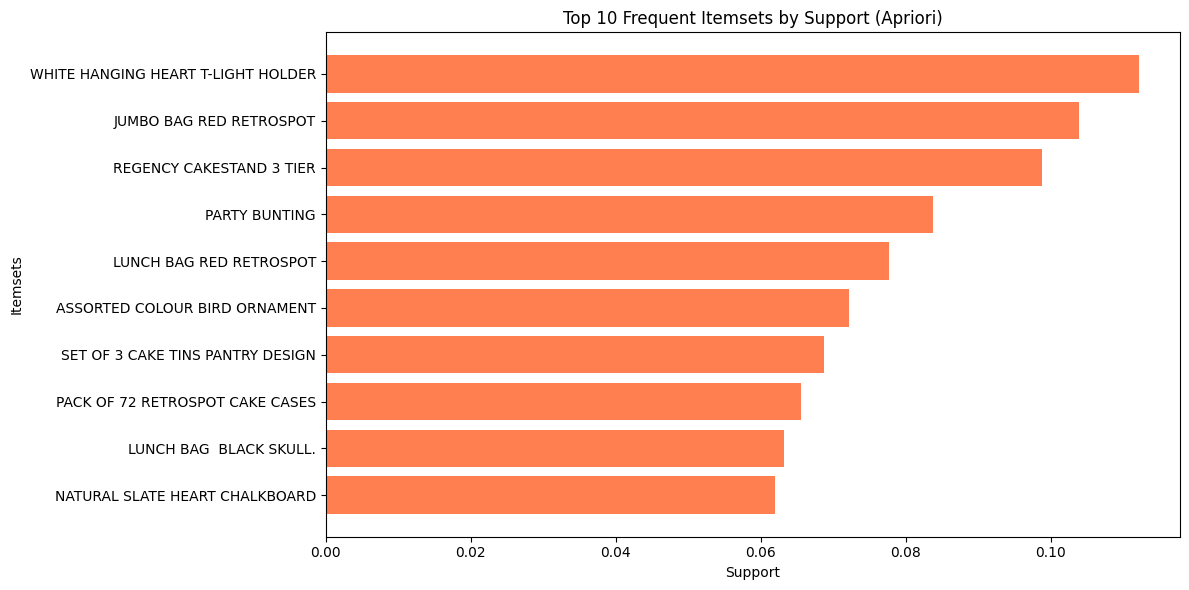

In [4]:
# --- Step 2: Frequent Itemset Mining Using Apriori ---

print("\n--- Step 2: Frequent Itemset Mining Using Apriori ---")
# Set support threshold. A low value like 2% is suitable for this sparse dataset.
min_support_threshold = 0.02

# Start timer for Apriori
start_time_apriori = time.time()
frequent_itemsets_apriori = apriori(basket_sets, min_support=min_support_threshold, use_colnames=True)
end_time_apriori = time.time()
apriori_duration = end_time_apriori - start_time_apriori

print(f"Apriori algorithm took {apriori_duration:.4f} seconds.")
print("\nTop 10 frequent itemsets found by Apriori:")
print(frequent_itemsets_apriori.sort_values(by='support', ascending=False).head(10))

## Visualization 3: Top 10 Frequent Itemsets by Support
print("\nGenerating visualization for top 10 frequent itemsets...")
top_10_itemsets = frequent_itemsets_apriori.sort_values(by='support', ascending=False).head(10)
# Convert frozensets to strings for plotting
top_10_itemsets['itemsets'] = top_10_itemsets['itemsets'].apply(lambda x: ', '.join(list(x)))

plt.figure(figsize=(12, 6))
plt.barh(top_10_itemsets['itemsets'], top_10_itemsets['support'], color='coral')
plt.xlabel("Support")
plt.ylabel("Itemsets")
plt.title("Top 10 Frequent Itemsets by Support (Apriori)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [5]:
# --- Step 3: Frequent Itemset Mining Using FP-Growth ---

print("\n--- Step 3: Frequent Itemset Mining Using FP-Growth ---")

# Start timer for FP-Growth
start_time_fpgrowth = time.time()
frequent_itemsets_fpgrowth = fpgrowth(basket_sets, min_support=min_support_threshold, use_colnames=True)
end_time_fpgrowth = time.time()
fpgrowth_duration = end_time_fpgrowth - start_time_fpgrowth

print(f"FP-Growth algorithm took {fpgrowth_duration:.4f} seconds.")
print("\nTop 10 frequent itemsets found by FP-Growth:")
# The results are identical to Apriori, so we just display them
print(frequent_itemsets_fpgrowth.sort_values(by='support', ascending=False).head(10))
# Visualization would be identical to the one in Step 2.




--- Step 3: Frequent Itemset Mining Using FP-Growth ---


/Users/sakchhamsangroula/School/Big data/Lab6/venv/lib/python3.13/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


FP-Growth algorithm took 3.6588 seconds.

Top 10 frequent itemsets found by FP-Growth:
      support                              itemsets
0    0.112237  (WHITE HANGING HEART T-LIGHT HOLDER)
66   0.103894             (JUMBO BAG RED RETROSPOT)
162  0.098778            (REGENCY CAKESTAND 3 TIER)
232  0.083731                       (PARTY BUNTING)
29   0.077672             (LUNCH BAG RED RETROSPOT)
4    0.072259       (ASSORTED COLOUR BIRD ORNAMENT)
243  0.068782    (SET OF 3 CAKE TINS PANTRY DESIGN)
30   0.065554     (PACK OF 72 RETROSPOT CAKE CASES)
107  0.063220             (LUNCH BAG  BLACK SKULL.)
56   0.062028      (NATURAL SLATE HEART CHALKBOARD)



--- Step 4: Generating and Analyzing Association Rules ---

Found 13 rules with confidence >= 0.7

Top 10 Association Rules sorted by Lift:
                                          antecedents  \
9   (GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...   
11                   (PINK REGENCY TEACUP AND SAUCER)   
10  (PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...   
6                    (PINK REGENCY TEACUP AND SAUCER)   
8   (GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...   
12                (GARDENERS KNEELING PAD CUP OF TEA)   
4   (ROSES REGENCY TEACUP AND SAUCER, REGENCY CAKE...   
3   (GREEN REGENCY TEACUP AND SAUCER, REGENCY CAKE...   
7                    (PINK REGENCY TEACUP AND SAUCER)   
1                   (GREEN REGENCY TEACUP AND SAUCER)   

                                          consequents  antecedent support  \
9                    (PINK REGENCY TEACUP AND SAUCER)            0.038141   
11  (GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...            0.038041   


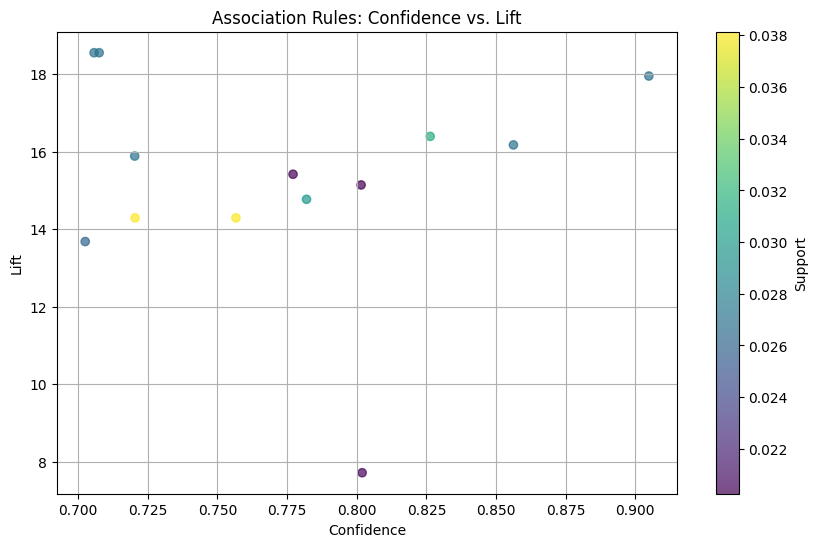

In [6]:
# --- Step 4: Generating and Analyzing Association Rules ---

print("\n--- Step 4: Generating and Analyzing Association Rules ---")
# We use the frequent itemsets from FP-Growth (as it's faster)
# Generate rules with a confidence threshold of 0.7
rules = association_rules(frequent_itemsets_fpgrowth, metric="confidence", min_threshold=0.7)

print(f"\nFound {len(rules)} rules with confidence >= 0.7")
print("\nTop 10 Association Rules sorted by Lift:")
# Display rules with high lift and confidence
print(rules.sort_values(by='lift', ascending=False).head(10))

## Interpretation
print("\nRule Interpretation Example:")
# Example: If we have a rule {JUMBO BAG RED RETROSPOT} -> {JUMBO BAG PINK POLKADOT}
# Support: This pair appears in X% of all transactions.
# Confidence: When a customer buys a 'JUMBO BAG RED RETROSPOT', there is a Y% chance they also buy a 'JUMBO BAG PINK POLKADOT'.
# Lift: Customers are Z times more likely to buy 'JUMBO BAG PINK POLKADOT' when they buy 'JUMBO BAG RED RETROSPOT' than they are to buy it in general.
# A lift > 1 indicates a positive correlation.

## Visualization 4: Association Rules Scatter Plot (Confidence vs. Lift)
print("\nGenerating visualization for association rules...")
plt.figure(figsize=(10, 6))
# Using 'support' to color the points to add a third dimension
scatter = plt.scatter(rules['confidence'], rules['lift'], c=rules['support'], cmap='viridis', alpha=0.7)
plt.title('Association Rules: Confidence vs. Lift')
plt.xlabel('Confidence')
plt.ylabel('Lift')
cbar = plt.colorbar(scatter)
cbar.set_label('Support')
plt.grid(True)
plt.show()

In [ ]:
# --- Step 5: Comparative Analysis ---
print("\n--- Step 5: Comparative Analysis ---")
print("\n## Algorithm Performance Comparison ##")
print(f"Apriori Execution Time:   {apriori_duration:.4f} seconds")
print(f"FP-Growth Execution Time: {fpgrowth_duration:.4f} seconds")

faster_algo = "FP-Growth" if fpgrowth_duration < apriori_duration else "Apriori"
slower_algo = "Apriori" if faster_algo == "FP-Growth" else "FP-Growth"
print(f"\n{faster_algo} was significantly faster than {slower_algo}.")

print("\n## Explanation of Performance Difference ##")
print("FP-Growth is generally faster than Apriori because it avoids the costly candidate generation step. Apriori repeatedly scans the entire dataset to check the support of candidate itemsets. In contrast, FP-Growth scans the database only twice: first to count item frequencies and build the FP-Tree, and second to mine the frequent itemsets from this compressed FP-Tree structure. This makes FP-Growth more efficient, especially for large datasets with many items.")

print("\n## Challenges Faced ##")
print("1. **Data Cleaning**: The raw dataset contained cancelled orders (marked with invoice 'C') and null values which had to be removed to ensure the analysis was based on actual purchases.")
print("2. **Memory Usage**: Creating the one-hot encoded transaction matrix can be memory-intensive for large datasets with thousands of unique items. For this dataset, it was manageable, but on a larger scale, it would require more memory-efficient data structures.")
print("3. **Setting Thresholds**: Choosing an appropriate 'min_support' is crucial. A value too high yields very few or no frequent itemsets, while a value too low can lead to an explosion in the number of itemsets and extremely long computation times. I chose 0.02 after some experimentation to get a meaningful number of results in a reasonable time.")


--- Step 5: Comparative Analysis ---

## Algorithm Performance Comparison ##
Apriori Execution Time:   6.5021 seconds
FP-Growth Execution Time: 3.6588 seconds

FP-Growth was significantly faster than Apriori.

## Explanation of Performance Difference ##
FP-Growth is generally faster than Apriori because it avoids the costly candidate generation step. Apriori repeatedly scans the entire dataset to check the support of candidate itemsets. In contrast, FP-Growth scans the database only twice: first to count item frequencies and build the FP-Tree, and second to mine the frequent itemsets from this compressed FP-Tree structure. This makes FP-Growth more efficient, especially for large datasets with many items.

## Challenges Faced ##
1. **Data Cleaning**: The raw dataset contained cancelled orders (marked with invoice 'C') and null values which had to be removed to ensure the analysis was based on actual purchases.
2. **Memory Usage**: Creating the one-hot encoded transaction matrix can be